**Import Liabrary**

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/IMDB Dataset.csv')
df = df.sample(n=10000,random_state=42).reset_index(drop=True)
# Show the DataFrame
df.head()


,review,sentiment
0,I really liked this Summerslam due to the look...,positive
1,Not many television shows appeal to quite as m...,positive
2,The film quickly gets to a major chase scene w...,negative
3,Jane Austen would definitely approve of this o...,positive
4,Expectations were somewhat high for me when I ...,negative


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
positive,5039
negative,4961


**Step 2: Preprocessing (Lowercasing, Removing Punctuation, Tokenization)**

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Preprocess function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Remove extra spaces
    text = ' '.join(text.split())

    return text

# Apply preprocessing
df['cleaned_text'] = df['review'].apply(preprocess_text)

df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,review,sentiment,cleaned_text
0,I really liked this Summerslam due to the look...,positive,really liked summerslam due look arena curtain...
1,Not many television shows appeal to quite as m...,positive,many television shows appeal quite many differ...
2,The film quickly gets to a major chase scene w...,negative,film quickly gets major chase scene ever incre...
3,Jane Austen would definitely approve of this o...,positive,jane austen would definitely approve onegwynet...
4,Expectations were somewhat high for me when I ...,negative,expectations somewhat high went see movie thou...


**Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the sentiment labels (positive -> 1, negative -> 0)
df['encoded_sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [ ]:
df.head()

,review,sentiment,cleaned_text,encoded_sentiment
0,I really liked this Summerslam due to the look...,positive,really liked summerslam due look arena curtain...,1
1,Not many television shows appeal to quite as m...,positive,many television shows appeal quite many differ...,1
2,The film quickly gets to a major chase scene w...,negative,film quickly gets major chase scene ever incre...,0
3,Jane Austen would definitely approve of this o...,positive,jane austen would definitely approve onegwynet...,1
4,Expectations were somewhat high for me when I ...,negative,expectations somewhat high went see movie thou...,0


**Tokenization and Padding**

In [ ]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer setup
tokenizer = Tokenizer(num_words=10000, oov_token="")
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert text to sequences (integer representation)
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

In [ ]:
df.head()

,review,sentiment,cleaned_text,encoded_sentiment
0,I really liked this Summerslam due to the look...,positive,really liked summerslam due look arena curtain...,1
1,Not many television shows appeal to quite as m...,positive,many television shows appeal quite many differ...,1
2,The film quickly gets to a major chase scene w...,negative,film quickly gets major chase scene ever incre...,0
3,Jane Austen would definitely approve of this o...,positive,jane austen would definitely approve onegwynet...,1
4,Expectations were somewhat high for me when I ...,negative,expectations somewhat high went see movie thou...,0


In [ ]:
sequences[:2]

[[10,
  310,
  1,
  526,
  73,
  1,
  1,
  73,
  394,
  118,
  176,
  4941,
  28,
  4,
  41,
  1,
  44,
  5958,
  60,
  8066,
  9406,
  184,
  1269,
  1,
  9,
  544,
  503,
  1564,
  48,
  1565,
  482,
  48,
  58,
  970,
  113,
  1058,
  272,
  184,
  1269,
  5,
  75,
  909,
  9406,
  272,
  5058,
  3163,
  6570,
  7364,
  1565,
  2054,
  1,
  1,
  979,
  1565,
  1,
  1794,
  7365,
  5059,
  1565,
  1,
  1,
  1269,
  7365,
  614,
  92,
  559,
  531,
  2828,
  5610,
  1,
  1565,
  475,
  1,
  5461,
  20,
  199,
  1,
  199,
  1537,
  1,
  361,
  1,
  1,
  108,
  118,
  1,
  1,
  1985,
  4817,
  1,
  1,
  391,
  1373,
  1,
  64,
  272,
  909,
  3067,
  1,
  1,
  391,
  5959,
  5959,
  1,
  1,
  1,
  1,
  97,
  323,
  8066,
  9406,
  909,
  275,
  272,
  181,
  107,
  877],
 [30,
  514,
  159,
  1205,
  84,
  30,
  165,
  2366,
  322,
  5,
  9407,
  1,
  40,
  9408,
  62,
  1,
  843,
  541,
  30,
  165,
  2759,
  29,
  5462,
  142,
  2399,
  689,
  147,
  117,
  75,
  36,
  142,
  33,
  21

In [ ]:
max_len = max([len(seq) for seq in sequences])
max_len

641

In [ ]:
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

**Train a Simple RNN Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(
        input_dim=10000,
        output_dim=128,
        input_length=max_len,
        mask_zero=True          # IMPORTANT for padded sequences
    ),

    LSTM(
        128,
        return_sequences=False,
        dropout=0.3,
        recurrent_dropout=0.3
    ),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

optimizer = Adam(
    learning_rate=0.0003,   # LOWER LR
    clipnorm=1.0            # PREVENT exploding gradients
)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Train the model
history = model.fit(padded_sequences, df['encoded_sentiment'], epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9044 - loss: 0.2973 - val_accuracy: 0.8565 - val_loss: 0.3308
Epoch 2/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9317 - loss: 0.2201 - val_accuracy: 0.8570 - val_loss: 0.3515
Epoch 3/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9454 - loss: 0.1868 - val_accuracy: 0.8490 - val_loss: 0.3761
Epoch 4/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9535 - loss: 0.1468 - val_accuracy: 0.8495 - val_loss: 0.3740


**Plot the Loss**

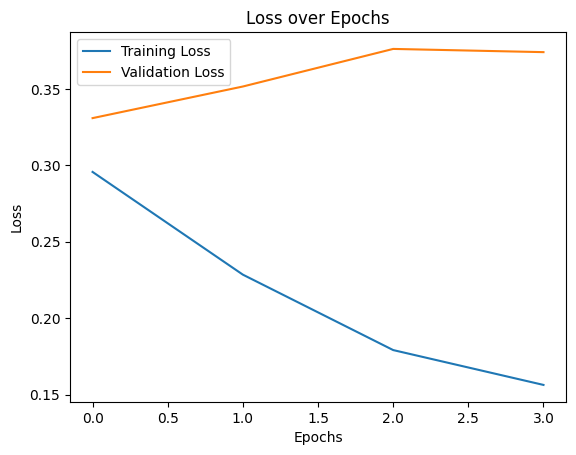

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Generate Classification Report and Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict the sentiment
y_pred = (model.predict(padded_sequences) > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(df['encoded_sentiment'], y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(df['encoded_sentiment'], y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 123s 393ms/step
Confusion Matrix:
 [[4785  176]
 [ 260 4779]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      4961
           1       0.96      0.95      0.96      5039

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



**Save and Load the Model**





In [ ]:

# Save the model
model.save('sentiment_lstm_model.keras')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('sentiment_lstm_model.keras')

In [ ]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:

def predict_sentiment(sentence):
    # Preprocess the input sentence
    sentence = preprocess_text(sentence)

    # Tokenize and pad the sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # Predict sentiment
    prediction = loaded_model.predict(padded_sequence)
    if prediction > 0.5:
        return "Positive"
    else:
        return "Negative"

# Test the prediction system
test_sentence = "I love this product!"
print(f"Sentiment: {predict_sentiment(test_sentence)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Sentiment: Positive


In [ ]:

# Test the prediction system
test_sentence = "I hate this movie!"
print(f"Sentiment: {predict_sentiment(test_sentence)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Sentiment: Positive
